<a href="https://colab.research.google.com/github/deshraja1/Next_Frame_Prediction/blob/main/Next_Frame_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.9 MB/s 
     |████████████████████████████████| 153 kB 67.5 MB/s 
     |████████████████████████████████| 181 kB 61.5 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=ddc0384871e1746312b2cdc79f1d50dd0051b5ff2093ec707c6d4b37f74c4532
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


# Importing required libraries

In [ ]:
from keras.models import Sequential
from keras.callbacks import Callback
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, UpSampling2D
from keras import backend as K

import random
import glob
import wandb
from wandb.keras import WandbCallback
import subprocess
import os
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow, figure

# Downloading Dataset 

In [ ]:
if not os.path.exists("catz"):
    print("Downloading catz dataset...")
    subprocess.check_output(
        "curl https://storage.googleapis.com/wandb/catz.tar.gz | tar xz", shell=True)

val_dir = 'catz/test'
train_dir = 'catz/train'

# WandB intialization

In [ ]:
!wandb login <your_api_key>

hyperparams = {"num_epochs": 100, 
          "batch_size": 128,
          "height": 96,
          "width": 96}

wandb.init(project="Next_Frame_Prediction", entity="deshraja1", config=hyperparams)
config = wandb.config 

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: deshraja1. Use `wandb login --relogin` to force relogin


# Generator to loop over train and test images


In [ ]:
def my_generator(batch_size, img_dir):
    """A generator that returns 5 images plus a result image"""
    cat_dirs = glob.glob(img_dir + "/*")
    counter = 0
    while True:
        input_images = np.zeros(
            (batch_size, config.width, config.height, 3 * 5))
        output_images = np.zeros((batch_size, config.width, config.height, 3))
        random.shuffle(cat_dirs)
        if (counter+batch_size >= len(cat_dirs)):
            counter = 0
        for i in range(batch_size):
            input_imgs = glob.glob(cat_dirs[counter + i] + "/cat_[0-5]*")
            imgs = [Image.open(img) for img in sorted(input_imgs)]
            input_images[i] = np.concatenate(imgs, axis=2)
            output_images[i] = np.array(Image.open(
                cat_dirs[counter + i] + "/cat_result.jpg"))
            input_images[i] /= 255.
            output_images[i] /= 255.
        yield (input_images, output_images)
        counter += batch_size
        
steps_per_epoch = len(glob.glob(train_dir + "/*")) // config.batch_size
validation_steps = len(glob.glob(val_dir + "/*")) // config.batch_size

# Callback to log the images


In [ ]:
class ImageCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        validation_X, validation_y = next(
            my_generator(15, val_dir))
        output = self.model.predict(validation_X)
        wandb.log({
            "input": [wandb.Image(np.concatenate(np.split(c, 5, axis=2), axis=1)) for c in validation_X],
            "output": [wandb.Image(np.concatenate([validation_y[i], o], axis=1)) for i, o in enumerate(output)]
        }, commit=False)

# Testing the generator

In [ ]:
gen = my_generator(2, train_dir)
videos, next_frame = next(gen)
videos[0].shape
next_frame[0].shape

(96, 96, 3)

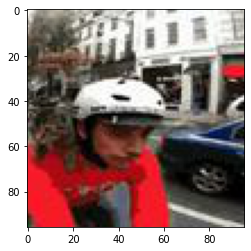

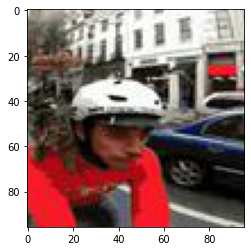

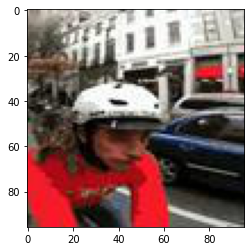

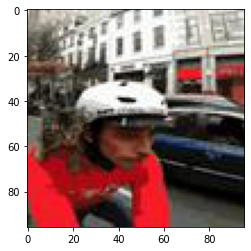

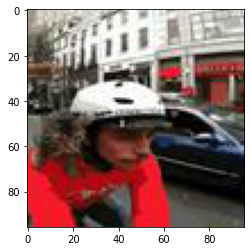

In [ ]:
figure()
imshow(videos[0][:,:,0:3])
figure()
imshow(videos[0][:,:,3:6])
figure()
imshow(videos[0][:,:,6:9])
figure()
imshow(videos[0][:,:,9:12])

figure()
imshow(next_frame[0][:,:,0:3])

# Function for measuring how similar two images are

In [ ]:
def perceptual_distance(y_true, y_pred):
    y_true *= 255.
    y_pred *= 255.
    rmean = (y_true[:, :, :, 0] + y_pred[:, :, :, 0]) / 2
    r = y_true[:, :, :, 0] - y_pred[:, :, :, 0]
    g = y_true[:, :, :, 1] - y_pred[:, :, :, 1]
    b = y_true[:, :, :, 2] - y_pred[:, :, :, 2]

    return K.mean(K.sqrt((((512+rmean)*r*r)/256) + 4*g*g + (((767-rmean)*b*b)/256)))

# Baseline Model - just returns the last layer

In [ ]:
from keras.layers import Lambda, Reshape, Permute

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(project="Next_Frame_Prediction", entity="deshraja1", config=hyperparams)
config = wandb.config

model=Sequential()
model.add(Reshape((96,96,5,3), input_shape=(config.height, config.width, 5 * 3)))
model.add(Permute((1,2,4,3)))
model.add(Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3)))

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
13/13 [==============================] - 8s 577ms/step - loss: 0.0049 - perceptual_distance: 19.5849 - val_loss: 0.0048 - val_perceptual_distance: 17.2413 - _timestamp: 1658611556.0000 - _runtime: 17.0000
Epoch 2/100
13/13 [==============================] - 7s 590ms/step - loss: 0.0058 - perceptual_distance: 20.6653 - val_loss: 0.0042 - val_perceptual_distance: 18.9607 - _timestamp: 1658611563.0000 - _runtime: 24.0000
Epoch 3/100
13/13 [==============================] - 7s 575ms/step - loss: 0.0053 - perceptual_distance: 19.7993 - val_loss: 0.0046 - val_perceptual_distance: 19.0983 - _timestamp: 1658611570.0000 - _runtime: 31.0000
Epoch 4/100
13/13 [==============================] - 7s 581ms/step - loss: 0.0053 - perceptual_distance: 20.5166 - val_loss: 0.0050 - val_perceptual_distance: 19.7972 - _timestamp: 1658611578.0000 - _runtime: 39.0000
Epoch 5/100
13/13 [==============================] - 7s 572ms/step - loss: 0.0055 - perceptual_distance: 19.9446 - val_loss: 0.0048 

# Conv3D

In [ ]:
from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(project="Next_Frame_Prediction", entity="deshraja1", config=hyperparams)
config = wandb.config

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(permuted)
conv_output = Conv3D(1, (3,3,3), padding="same")(permuted)
conv_output_reshape = Reshape((96,96,3))(conv_output)
combined = add([last_layer, conv_output_reshape])

model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▂▄▄▆▂▃▃▂▇▂█▆▄▅▂▂▆▃▅▃▁▃█▅▇▅▆▃▆▅▄▄▃▂▃▆▅▄▂▆
perceptual_distance,▂▂▄▆▁▃▃▃▆▁▆▆▃▃▂▁▅▂▄▃▁▃█▃▆▃▄▂▆▅▆▄▄▂▂▆▅▆▂▆
val_loss,▄▄▄▆▅▃▃▃▆▃▃▄▃▃▄▆▄▃▃█▂▄▇▇▄▄▂▂██▂▂▄▇▄▄▁▂▅▄
val_perceptual_distance,▂▄▃▆▅▄▄▃▅▃▂▆▃▄▄▆▅▂▃█▃▄▆█▄▄▁▂▇▆▂▃▄█▅▅▁▃▆▄
GFLOPS,0.0
best_epoch,39
best_val_loss,0.00315
epoch,99
loss,0.00577
perceptual_distance,21.22261


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/100
13/13 [==============================] - 18s 602ms/step - loss: 0.2446 - perceptual_distance: 310.8539 - val_loss: 0.0295 - val_perceptual_distance: 103.6060 - _timestamp: 1658612275.0000 - _runtime: 24.0000
Epoch 2/100
13/13 [==============================] - 7s 577ms/step - loss: 0.0347 - perceptual_distance: 111.1465 - val_loss: 0.0431 - val_perceptual_distance: 134.9565 - _timestamp: 1658612282.0000 - _runtime: 31.0000
Epoch 3/100
13/13 [==============================] - 8s 615ms/step - loss: 0.0316 - perceptual_distance: 106.0771 - val_loss: 0.0213 - val_perceptual_distance: 68.8941 - _timestamp: 1658612290.0000 - _runtime: 39.0000
Epoch 4/100
13/13 [==============================] - 7s 604ms/step - loss: 0.0214 - perceptual_distance: 76.9551 - val_loss: 0.0182 - val_perceptual_distance: 72.4850 - _timestamp: 1658612297.0000 - _runtime: 46.0000
Epoch 5/100
13/13 [==================

# Conv3D with Gaussain Noise

In [ ]:
from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(project="Next_Frame_Prediction", entity="deshraja1", config=hyperparams)
config = wandb.config

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(noise)
conv_output = Conv3D(1, (3,3,3), padding="same")(noise)
conv_output_reshape = Reshape((96,96,3))(conv_output)
combined = add([last_layer, conv_output_reshape])

model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perceptual_distance,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▄▃▄▄▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁
val_perceptual_distance,█▅▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
GFLOPS,0.00375
best_epoch,88
best_val_loss,0.00565
epoch,99
loss,0.00771
perceptual_distance,34.8955


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
13/13 [==============================] - 8s 629ms/step - loss: 0.4477 - perceptual_distance: 444.5210 - val_loss: 0.0895 - val_perceptual_distance: 191.5759 - _timestamp: 1658613019.0000 - _runtime: 14.0000
Epoch 2/100
13/13 [==============================] - 7s 599ms/step - loss: 0.0698 - perceptual_distance: 179.9804 - val_loss: 0.0442 - val_perceptual_distance: 147.1706 - _timestamp: 1658613027.0000 - _runtime: 22.0000
Epoch 3/100
13/13 [==============================] - 7s 578ms/step - loss: 0.0706 - perceptual_distance: 189.0699 - val_loss: 0.0336 - val_perceptual_distance: 121.4614 - _timestamp: 1658613034.0000 - _runtime: 29.0000
Epoch 4/100
13/13 [==============================] - 7s 601ms/step - loss: 0.0502 - perceptual_distance: 151.1537 - val_loss: 0.0244 - val_perceptual_distance: 85.5612 - _timestamp: 1658613041.0000 - _runtime: 36.0000
Epoch 5/100
13/13 [==============================] - 7s 589ms/step - loss: 0.0475 - perceptual_distance: 144.1575 - val_loss:

# Conv2DLSTM with Gaussian Noise

In [ ]:
from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise, ConvLSTM2D
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(project="Next_Frame_Prediction", entity="deshraja1", config=hyperparams)
config = wandb.config

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(noise)
permuted_2 = Permute((4,1,2,3))(noise)

conv_lstm_output_1 = ConvLSTM2D(6, (3,3), padding='same')(permuted_2)
conv_output = Conv2D(3, (3,3), padding="same")(conv_lstm_output_1)
combined = add([last_layer, conv_output])

model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perceptual_distance,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_perceptual_distance,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
GFLOPS,0.00375
best_epoch,96
best_val_loss,0.00399
epoch,99
loss,0.01814
perceptual_distance,88.90913


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
13/13 [==============================] - 13s 754ms/step - loss: 0.0228 - perceptual_distance: 99.3882 - val_loss: 0.0071 - val_perceptual_distance: 45.0736 - _timestamp: 1658613776.0000 - _runtime: 19.0000
Epoch 2/100
13/13 [==============================] - 9s 721ms/step - loss: 0.0181 - perceptual_distance: 87.9860 - val_loss: 0.0045 - val_perceptual_distance: 33.5785 - _timestamp: 1658613786.0000 - _runtime: 29.0000
Epoch 3/100
13/13 [==============================] - 9s 703ms/step - loss: 0.0164 - perceptual_distance: 83.8541 - val_loss: 0.0055 - val_perceptual_distance: 32.3808 - _timestamp: 1658613795.0000 - _runtime: 38.0000
Epoch 4/100
13/13 [==============================] - 9s 723ms/step - loss: 0.0161 - perceptual_distance: 82.8978 - val_loss: 0.0064 - val_perceptual_distance: 31.1269 - _timestamp: 1658613804.0000 - _runtime: 47.0000
Epoch 5/100
13/13 [==============================] - 9s 706ms/step - loss: 0.0162 - perceptual_distance: 82.6043 - val_loss: 0.0055